## 1. Import data

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

sys.path.append("../src")
import segment

In [2]:
df = pd.read_csv("../data/raw/training_data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [3]:
df.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
residence_type           0
avg_glucose_level        0
bmi                   1180
smoking_status       10775
stroke                   0
dtype: int64

## 2. Data Preprocessing

In [4]:
df['female'] = df['gender'].apply(lambda x: 1 if x == 'Female' else 0)
df['ever_married'] = df['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)
df['residence_rural'] = df['residence_type'].apply(lambda x: 1 if x == 'Rural' else 0)

In [5]:
df.drop(['id', 'gender', 'work_type', 'residence_type', 'smoking_status', 'bmi'], axis=1, inplace=True)
df.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,stroke,female,residence_rural
0,3.0,0,0,0,95.12,0,0,1
1,58.0,1,0,1,87.96,0,0,0
2,8.0,0,0,0,110.89,0,1,0
3,70.0,0,0,1,69.04,0,1,1
4,14.0,0,0,0,161.28,0,0,1


In [6]:
df.isnull().sum()

age                  0
hypertension         0
heart_disease        0
ever_married         0
avg_glucose_level    0
stroke               0
female               0
residence_rural      0
dtype: int64

## 3. KMeans Segmentation (4 segments)

In [7]:
kmeans_new = KMeans(4)
#Fit the data
kmeans_new.fit(df)
#Create a new data frame with the predicted clusters
clusters_new = df.copy()
clusters_new['cluster_pred'] = kmeans_new.fit_predict(df)

In [19]:
kmeans_new.cluster_centers_

array([[5.93612483e+01, 1.38790873e-01, 6.93170234e-02, 9.17039128e-01,
        8.27945581e+01, 2.57194386e-02, 6.05583000e-01, 4.97373167e-01],
       [5.96212828e+01, 2.47979798e-01, 1.47979798e-01, 8.80555556e-01,
        2.09041619e+02, 5.40404040e-02, 5.37121212e-01, 5.00000000e-01],
       [3.91779312e+01, 6.56990069e-02, 2.71963331e-02, 6.49961803e-01,
        1.23169699e+02, 1.02368220e-02, 6.06111536e-01, 5.01757066e-01],
       [1.97177367e+01, 1.24144920e-02, 1.01342792e-03, 2.68811756e-01,
        8.27485787e+01, 1.26678490e-03, 5.84494553e-01, 4.98268727e-01]])

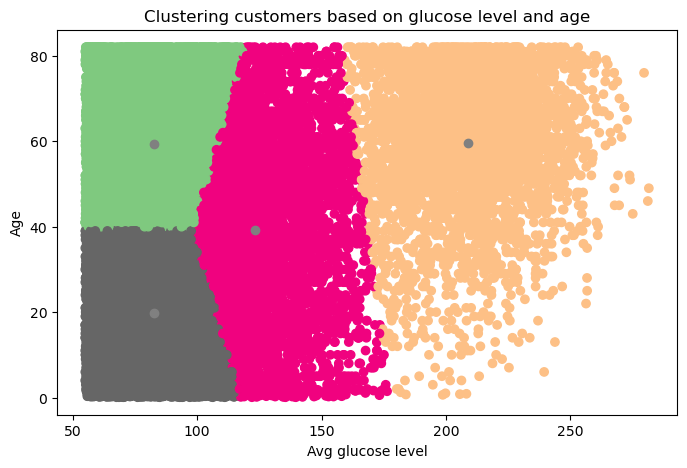

In [8]:
plt.figure(figsize=(8,5))
plt.scatter(clusters_new['avg_glucose_level'],clusters_new['age'],c=kmeans_new.labels_,cmap='Accent')
plt.scatter(kmeans_new.cluster_centers_[:, 4] ,kmeans_new.cluster_centers_[:, 0], color = 'grey')
plt.title("Clustering customers based on glucose level and age")
plt.xlabel("Avg glucose level")
plt.ylabel("Age")
plt.show()

## 4. PCA & KMeans Segmentation (3D graph)

In [9]:
pca = segment.get_pca_model(df)
pca_df = segment.reduce_dimension(df, pca)
pca_df.head()

,x,y,z
0,-15.613810,37.234327,0.512249
1,-13.845416,-18.212956,-0.485848
2,0.753982,34.831654,-0.505065
3,-30.594367,-33.092183,0.494523
4,51.453753,37.003826,0.509363


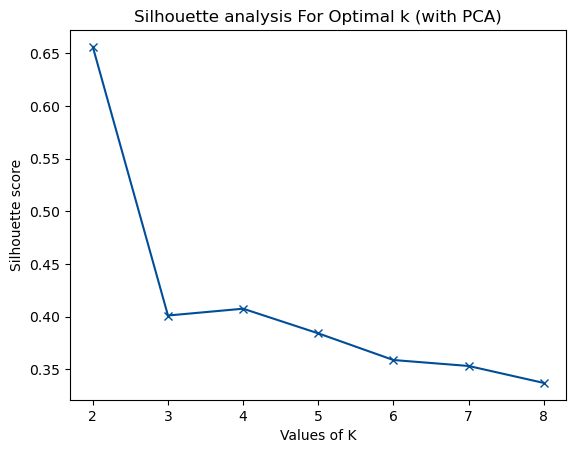

In [10]:
# silhouette score and graph
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(pca_df)
    cluster_labels = kmeans.labels_

# silhouette score
    silhouette_avg.append(segment.get_silhouette_score(pca_df, cluster_labels))

plt.plot(range_n_clusters, silhouette_avg, color = "#004E98", marker='x')
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k (with PCA)")
plt.show()

In [11]:
num_clusters = 3
model = KMeans(n_clusters=num_clusters)
yhat = model.fit_predict(pca_df)

In [12]:
pca_df = segment.insert_clusters_to_df(pca_df, yhat)

In [17]:
model.cluster_centers_

array([[-1.25644895e+01, -1.83622965e+01, -7.92900151e-04],
       [ 9.82342229e+01,  7.84788575e-01, -2.30930653e-03],
       [-1.73082030e+01,  1.91459282e+01,  1.55607252e-03]])

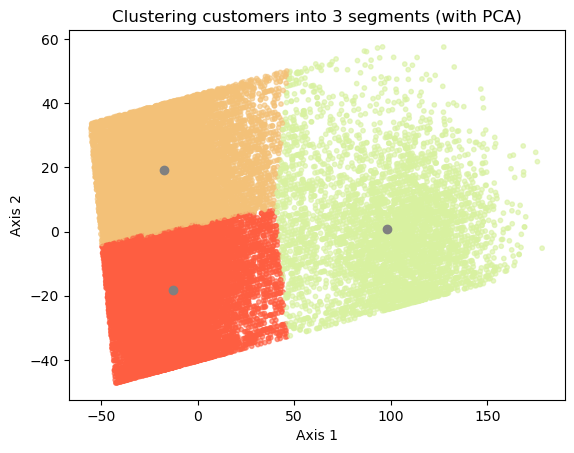

In [24]:
# get centroids
centroids = model.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to df
pca_df['cen_x'] = pca_df.clusters.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
pca_df['cen_y'] = pca_df.clusters.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
# colors = ['#DF2020', '#81DF20', '#2095DF']
colors = ['#FE5E41', '#D8F1A0', '#F3C178']
pca_df['c'] = pca_df.clusters.map({0:colors[0], 1:colors[1], 2:colors[2]})
plt.scatter(pca_df['x'], pca_df['y'], c=pca_df.c, alpha = 0.6, s=10)
plt.scatter(model.cluster_centers_[:, 0] ,model.cluster_centers_[:, 1], color = 'grey')
plt.title("Clustering customers into 3 segments (with PCA)")
plt.xlabel("Axis 1")
plt.ylabel("Axis 2")
plt.show()

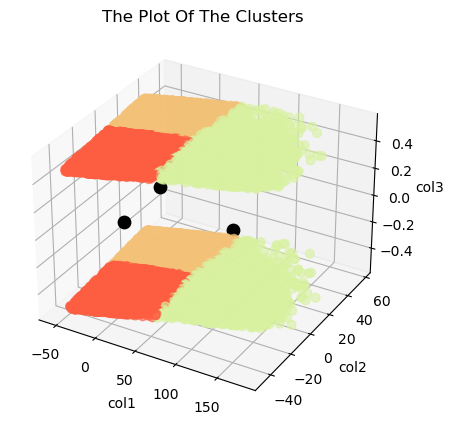

In [14]:
centroids = model.cluster_centers_
segment.plot_clusters(pca_df, yhat, centroids)

In [15]:
pca_df['clusters'].value_counts()

0    15639
2    14844
1     4616
Name: clusters, dtype: int64